In [1]:
!pip install unidecode
!pip install contractions

     |████████████████████████████████| 245kB 2.1MB/s 
     |████████████████████████████████| 317kB 2.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81702 sha256=5c16714cd5f08f3de48a0cc06a10de52e64e6d66a1bb88bccdf0219905fe9c88
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


# <font color='slateblue'>Function</font>

## Cleaning data

In [2]:
from bs4 import BeautifulSoup 
import unidecode
import contractions
from gensim.parsing.preprocessing import remove_stopwords
import re
from nltk.stem.porter import PorterStemmer

def preprocessing(text):
  ### Removed HTML Tags - <> ###
  text = BeautifulSoup(text, 'html.parser')
  text = text.get_text(separator=' ')
  ### Convert Accented Characters ###
  text = unidecode.unidecode(text)
  ### Expand Contractions - don't ###
  text = contractions.fix(text)
  ### Removed Stopwords ###
  text = remove_stopwords(text)
  ### Removed URL ###
  text = re.sub(r'http\S+', '', text)
  ### Removed All Irrelevant Characters ###
  text = re.sub('[^a-zA-Z]', ' ', text)
  ### Convert All Characters into lowercase  ###
  text = text.lower()
  ### Removed not less than 2 words ###
  text = [word for word in text.split() if len(word) > 3]
  ### Stemming ###
  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]
  ### Concated ###
  cleaned_text = ' '.join(text)
  
  return cleaned_text

## Get F1 score

In [3]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

# <font color='slateblue'>Static</font>

In [4]:
TRAIN_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/train.csv'
TEST_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/test.csv'

BATCH_SIZE = 32
EPOCHS = 10
VALIDATION_SPLIT = 0.2

# <font color='slateblue'>Import Data and Prepocessing</font>

In [5]:
import pandas as pd

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# train_data = df_train['html_content'].apply(preprocessing)
# test_data = df_test['html_content'].apply(preprocessing)
# data = pd.concat([df_train['html_content'], df_test['html_content']], axis=0).apply(preprocessing)

train_data = df_train['html_content']
test_data = df_test['html_content']
data = pd.concat([df_train['html_content'], df_test['html_content']], axis=0)

print('train_data shape: {0}'.format(train_data.shape))
print('test_data shape: {0}'.format(test_data.shape))
print('data shape: {0}'.format(data.shape))

train_data shape: (10545,)
test_data shape: (10544,)
data shape: (21089,)


# <font color='slateblue'>Tokenizer</font>

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

### 特徴量として考慮する単語の数 ###
# max_features = 1000
max_features = 5000
# max_features = 10000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data)

### 出現頻度の高い単語を取得 ###
X_train = tokenizer.texts_to_sequences(train_data)
X_test = tokenizer.texts_to_sequences(test_data)

# max_len = 100
max_len = 500
# max_len = 1000

X_train = pad_sequences(X_train, maxlen=max_len)
Y_train = df_train['state'].astype(int).values
X_test = pad_sequences(X_test, maxlen=max_len)

print('X_train: {0}'.format(X_train.shape))
print('Y_train: {0}'.format(Y_train.shape))
print('X_test: {0}'.format(X_test.shape))

X_train: (10545, 500)
Y_train: (10545,)
X_test: (10544, 500)


# <font color='slateblue'>Create Model</font>

## Embedding

In [7]:
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense
# from keras.optimizers import RMSprop
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy

# model = Sequential()

# model.add(Embedding(max_features, BATCH_SIZE, input_length=max_len))
# model.add(Flatten())
# model.add(Dense(1, 'sigmoid'))

# model.compile(optimizer=RMSprop(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

## SimpleRNN

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

model = Sequential()

model.add(Embedding(max_features, BATCH_SIZE, input_length=max_len))
model.add(SimpleRNN(BATCH_SIZE))
model.add(Dense(1, 'sigmoid'))

model.compile(optimizer=RMSprop(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

## LSTM

In [17]:
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense, BatchNormalization
# from keras.optimizers import RMSprop
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy

# model = Sequential()

# model.add(Embedding(max_features, BATCH_SIZE, input_length=max_len))
# model.add(LSTM(BATCH_SIZE))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=RMSprop(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

## 1d CNN

In [18]:
# from keras.models import Sequential
# from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
# from keras.optimizers import RMSprop
# from keras.losses import binary_crossentropy
# from keras.metrics import binary_accuracy

# model = Sequential()

# model.add(Embedding(max_features, BATCH_SIZE, input_length=max_len))
# model.add(Conv1D(BATCH_SIZE, 10, activation='relu'))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(BATCH_SIZE, 7, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(1, 'sigmoid'))

# model.compile(optimizer=RMSprop(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

# <font color='slateblue'>Train Model</font>

|Model|validation f1 score|Public Leaderboard|
|:--:|:--:|:--:|
|Embedding|0.7133 [best - 2 epochs] 0.6865 [last]|Nan|
|SimpleRNN|0.6732 [best - 2 epochs] 0.6087 [last]|Nan|
|LSTM|0.7035 [best - 2 epochs] 0.6072 [last]|Nan|
|1d CNN|0.7335 [best - 6 epochs] 0.6522 [last]|Nan|

|Model|max_features|max_len|validation f1 score|Public Leaderboard|
|:--:|:--:|:--:|:--:|:--:|
|LSTM|5000|100|0.7133 [best - 1 epoch] 0.6986 [last]|Nan|
|LSTM|5000|500|0.7173 [best - 1 epoch] 0.6622 [last]|Nan|
|LSTM|5000|1000|0.7263 [best - 2 epochs] 0.6467 [last]|Nan|
|LSTM|1000|1000|0.7140 [best] 0.6838 [last]|Nan|
|LSTM|10000|1000|0.7094 [best - 4 epochs] 0.7202 [last]|Nan|

In [19]:
history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
264/264 [==============================] - 85s 320ms/step - loss: 0.6902 - binary_accuracy: 0.5283 - f1_score: 0.5215 - val_loss: 0.6968 - val_binary_accuracy: 0.5083 - val_f1_score: 0.5996
Epoch 2/10
264/264 [==============================] - 86s 325ms/step - loss: 0.6509 - binary_accuracy: 0.6351 - f1_score: 0.6259 - val_loss: 0.6757 - val_binary_accuracy: 0.5884 - val_f1_score: 0.5288
Epoch 3/10
264/264 [==============================] - 84s 320ms/step - loss: 0.5790 - binary_accuracy: 0.7104 - f1_score: 0.7213 - val_loss: 0.6644 - val_binary_accuracy: 0.6098 - val_f1_score: 0.6304
Epoch 4/10
264/264 [==============================] - 84s 319ms/step - loss: 0.4933 - binary_accuracy: 0.7747 - f1_score: 0.7753 - val_loss: 0.7519 - val_binary_accuracy: 0.5927 - val_f1_score: 0.6347
Epoch 5/10
264/264 [==============================] - 84s 317ms/step - loss: 0.3350 - binary_accuracy: 0.8593 - f1_score: 0.8626 - val_loss: 0.7985 - val_binary_accuracy: 0.5899 - val_f1_score: 0.

# <font color='slateblue'>Plot</font>

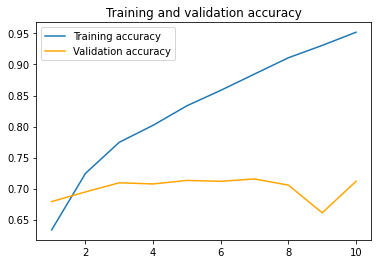

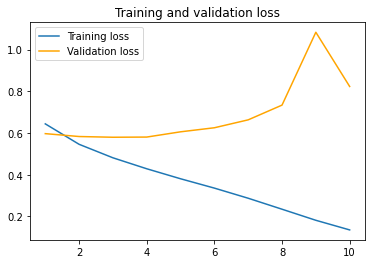

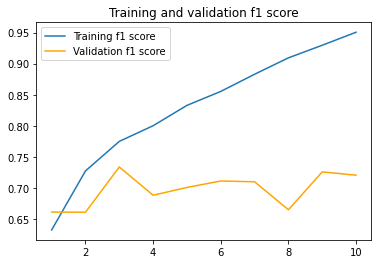

In [12]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, EPOCHS+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

# <font color='slateblue'>Prediction and Submission</blue>

In [13]:
import numpy as np

predicted = model.predict(X_test)

df_sub = pd.concat([df_test['id'], pd.DataFrame(np.round(predicted), columns=['predicted']).astype(int)], axis=1)
# df_sub = pd.concat([df_test['id'], pd.DataFrame(predicted, columns=['predicted'])], axis=1)

print('df_sub shape: {0}'.format(df_sub.shape))

df_sub.to_csv('submission.csv', index=False, header=False)
# df_sub.to_csv('/content/drive/MyDrive/SIGNATE/DATASET/LSTM.csv', index=False, header=False)

df_sub.head()

df_sub shape: (10544, 2)


,id,predicted
0,10545,0
1,10546,1
2,10547,1
3,10548,0
4,10549,1
